In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam

import gym
import numpy as np

In [4]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

In [5]:
tf.keras.backend.set_floatx('float64')

# actor를 최적화
ce_loss = SparseCategoricalCrossentropy(from_logits=True)
mse_loss = MeanSquaredError()

gamma = 0.99
update_interval = 5

actor_lr = 0.001
critic_lr = 0.001

print_freq = 10
do_render = False

In [8]:
# from_logits: output이 확률분포를 가정할 때 (더해서 1)
# 그렇지 않을 때 True
# True : keras가 알아서 softmax 해줍니다.

cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
target = [[1., 0., 0.,], [0., 1., 0.,]] # one-hot

sparse_cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sparse_target = [[0]], [[1]] # constant target

output = [[1.0, 0., 0.,],[0.05, 0.89, 0.06]]

print(cce(target, output))
print(sparse_cce(sparse_target, output))

tf.Tensor(0.5880922, shape=(), dtype=float32)
tf.Tensor(0.5880922, shape=(), dtype=float32)


In [5]:
def show_state(env, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(info)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [12]:
# policy network
# 정책을 학습하는 모델
class Actor(tf.keras.Model):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = self.create_model()
        self.optimizer = Adam(actor_lr)

    def create_model(self):
        net = tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])
        return net

    def call(self, x):
        x = tf.Variable(x)
        return self.net(x)

    def get_action(self, state):
        # hint: a2c is a policy gradient
        state = state[np.newaxis, ...] # (batch_size) 만들어주기
        policy = self.net(state)[0]
        action = np.random.choice(list(range(self.action_dim)), p=policy)
        return action
    
    def compute_loss(self, actions, policies, advantages):
        indiced_actions = tf.constant([[i, a[0]] for i, a in enumerate(actions)])
        chosen_prob = tf.gather_nd(policies, indiced_actions)
        # advantage : critic이 판단해준 평균적 value에 비해 어느정도 이득을 얻을 수 있는지
        loss = -tf.reduce_sum(tf.math.log(chosen_prob) * advantages)
        return loss

    def train(self, states, actions, advantages):
        with tf.GradientTape() as tape:
            policies = self.net(states)
            # tf.stop_gradient는 advantage를 feed-forward할 때 만든 gradient 무시
            # 모델 업데이트하려고하는 ground truth : 상수화
            loss = self.compute_loss(actions, policies, tf.stop_gradient(advantages))
        grads = tape.gradient(loss, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))

In [16]:
# value function approximator
# 가치를 평가하는 모델
# value(s) --> 끝날때까지 얼마의 보상을 평균적으로 받을 수 있을까?
# functional approximator : input (state_dim) --> output (1)

class Critic(tf.keras.Model):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.net = self.create_model()
        self.optimizer = Adam(critic_lr)

    def create_model(self):
        net = tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        return net

    def call(self, x):
        x = tf.Variable(x)
        return self.net(x)

    # v_pred: V_\phi(s)
    # td_targets: Q_t
    def compute_loss(self, v_pred, td_targets):
        return mse_loss(td_targets, v_pred) # 순서 상관없음

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.net(states, training=True)
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets)) # tf.stop_gradient(td_targets) : 정답 gradient 상수로 만들어줌
        grads = tape.gradient(loss, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))

In [17]:
class Agent:
    def __init__(self, env):
        super(Agent, self).__init__()
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
    
        self.actor = Actor(self.state_dim, self.action_dim)
        self.critic = Critic(self.state_dim) # value network이라서 action_dim 필요 X

    def td_target(self, reward, next_state, done):
        # r + V(s_(t+1)) (수식 파란부분의 앞에 두개의 term)
        next_value = self.critic(next_state)[0]
        td_target = reward + (1. - done) * next_value
        return np.reshape(td_target, [1, 1])

    def advantage(self, td_targets, baselines):
        # 26쪽 수식의 파란색 부분
        # td_target - V(s_t)
        # r_t + V(s_t+1) - V(s) > 0 : s_t+1 : 좋은 action
        # r_t + V(s_t+1) - V(s) < 0 : s_t+1 : 안좋은 action
        # V 값은 모르기 때문에 Neural Network 사용해서 추정(Critic)
        # 강의자료 23쪽의 현재 보상 + 미래의 가치 - 현재 가치
        # actor를 업데이트하는데 이용
        return td_targets - baselines

    def train_actor_and_critic(self, state_list, action_list, td_target_list, advantage_list):
        # shape을 맞추기 위한 소스
        # (step_size, dim)
        states = np.vstack(state_list)
        actions = np.vstack(action_list)
        td_targets = np.vstack(td_target_list)
        advantages = np.vstack(advantage_list)

        # critic: td_target과 현재 value와의 차이를 이용하여 학습
        self.critic.train(states, td_targets)
        # actor: advantage 학습 시그널로 이용
        # vanilla PG: reward를 학습 시그널로 이용
        self.actor.train(states, actions, advantages)

    def train(self, max_episodes=1000):
        total_reward = []

        for ep in range(max_episodes):
            done, running_reward = False, 0
            state_list, action_list, td_target_list, advantage_list = [], [], [], [] # update할 떄 마다 새로 정의됨(on-policy)
            state = self.env.reset()

            while not done: # episode가 끝날 때까지 step 진행
                action = self.actor.get_action(state)
                next_state, reward, done, _ = self.env.step(action)

                state = state[np.newaxis, ...]
                action = action[np.newaxis, ...]
                next_state = next_state[np.newaxis, ...]
                reward = np.reshape(reward, [1, 1])

                # r + V(s_(t+1)) (수식 파란부분의 앞에 두개의 term)
                # 매 스텝 td_target을 계산
                # critic (value network)을 학습하는데 이용
                td_target = self.td_target(0.01 * reward, next_state, done)
                # 수식의 파란색 부분
                # td_target - V(s_t)
                # 강의자료 23쪽의 현재 보상 + 미래의 가치 - 현재 가치
                # actor를 업데이트하는데 이용
                # actor (policy network)을 학습하는데 이용
                advantage = self.advantage(td_target, self.critic(state)) # self.critic(state) : 현재 state의 value값(의 예측값)

                # 나중에 쓰기 위해 list에 덧붙이기
                state_list.append(state)
                action_list.append(action)
                td_target_list.append(td_target)
                advantage_list.append(advantage)

                # 여기 들어올때마다 네트워크 back prop으로 업데이트
                # update_interval만큼 (s, a, r)기록이 생겼거나 done
                if len(state_list) >= update_interval or done:
                    self.train_actor_and_critic(state_list, action_list, td_target_list, advantage_list)
                    # 기록을 최신으로 유지
                    state_list, action_list, td_target_list, advantage_list = [], [], [], []

                running_reward += reward[0][0]
                state = next_state[0]

                if do_render:
#                     self.env.render()  # if you are running on a local machine
                    show_state(self.env, info=f'episode: {ep} | episode reward: {running_reward}')

            total_reward.append(running_reward)

            if ep % print_freq == 0:
                # :>3 오른쪽 정렬(세칸)
                print(f'episode: {ep:>3} | avg. reward: {np.mean(total_reward[-print_freq:])}')
        return total_reward

In [18]:
env = gym.make('CartPole-v1')
agent = Agent(env)
total_reward = agent.train(max_episodes=200)

episode:   0 | avg. reward: 22.0
episode:  10 | avg. reward: 21.9
episode:  20 | avg. reward: 24.0
episode:  30 | avg. reward: 19.3
episode:  40 | avg. reward: 22.4
episode:  50 | avg. reward: 25.4
episode:  60 | avg. reward: 19.7
episode:  70 | avg. reward: 24.4
episode:  80 | avg. reward: 26.5
episode:  90 | avg. reward: 28.7
episode: 100 | avg. reward: 30.7
episode: 110 | avg. reward: 59.7
episode: 120 | avg. reward: 112.5
episode: 130 | avg. reward: 101.7
episode: 140 | avg. reward: 165.0
episode: 150 | avg. reward: 148.4
episode: 160 | avg. reward: 162.9
episode: 170 | avg. reward: 257.2
episode: 180 | avg. reward: 137.1
episode: 190 | avg. reward: 77.6


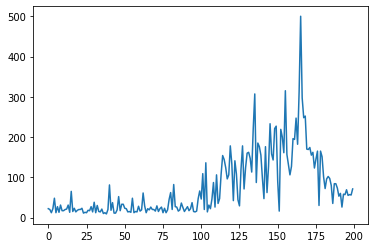

In [20]:
# 정말 좋은 알고리즘/모델을 어떻게 구분할 수 있는가?
# 1) moving average, variance까지 다 그려보기
# 2) env를 여러개 test
plt.plot(range(200), total_reward)
plt.show()

In [24]:
agent.actor([[1.,2.,3.,4.]]) # policy network의 output
agent.critic([[1., 2., 3., 4.]]) # value network의 output


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-0.91416381]])>